# This example shows how to use the IF to detect noisy labels in the MNIST.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/carolinef35/dattri/blob/colab_examples/examples/quickstart/influence_function_noisy_label.ipynb)

Note: The installation block in the notebook is specifically designed for Google Colab and the use cases in this notebook. Standard installation instructions can me found in the [README](https://github.com/TRAIS-Lab/dattri/blob/main/README.md#quick-start).

In [ ]:
!pip install dattri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=fd5739ba3229b2d5d8d6f2a149d3ef913fab1df96517502ff5a2b98bf9bdbee7
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty-midi


Import libraries needed to run code.

In [ ]:
import argparse
from functools import partial

import torch
from torch import nn

from dattri.algorithm.influence_function import (
    IFAttributorArnoldi,
    IFAttributorCG,
    IFAttributorDataInf,
    IFAttributorExplicit,
    IFAttributorLiSSA,
)
from dattri.benchmark.datasets.mnist import create_mnist_dataset, train_mnist_lr
from dattri.benchmark.utils import SubsetSampler, flip_label
from dattri.metric import mislabel_detection_auc
from dattri.task import AttributionTask

Dictionary to manage and intialize different influence function algorithms with their specific configurations. Each key is a specific arritbution method and the corresponding value is a class constructor with some of its arguments already pre-filled.

In [ ]:
ATTRIBUTOR_MAP = {
    "explicit": partial(IFAttributorExplicit, regularization=0.01),
    "cg": partial(IFAttributorCG, regularization=0.01),
    "lissa": partial(IFAttributorLiSSA, recursion_depth=100),
    "datainf": partial(IFAttributorDataInf, regularization=0.01),
    "arnoldi": partial(IFAttributorArnoldi, regularization=0.01, max_iter=10),
}

Influence Score: how much a single training data point affects the model's parameters or its predictions on other data points.


*   Higher influence indicates that a particular data point is problematic for the model.
*   Mislabeled samples will exert a stronger, often negative, influence on the model's traning process.


AUC Score: the probability that the influence function method ranks a randomly chosen positive example (a truly mislabled sample) higher than a randomly chosen negative example (a correctly labeled sample).


*   Higher AUC values indicate better performance.
*   For mislabel detection, an AUC close to 1.0 means the influence scores are very effective at identifying the flipped labels among the correctly labeled ones.



In [ ]:
# initialize argument parser for command-line arguments
parser = argparse.ArgumentParser()
# add argument for choosing the influence function method
parser.add_argument("--method", type=str, default="explicit")
# dynamically set device to 'cuda' if available, otherwise 'cpu'
parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
# parse arguments (passing an empty list to ignore Jupyter/IPython specific args)
args = parser.parse_args([])

# load the training dataset
dataset, _ = create_mnist_dataset("./data")

# flip 10% of the labels in the first 1000 data points to simulate noisy data
# 'flip_index' stores the indices of the samples whose labels were flipped
dataset.targets[0:1000], flip_index = flip_label(dataset.targets[0:1000], p=0.1)

# create a DataLoader for full model training with a batch size of 64
train_loader_full = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    sampler=SubsetSampler(range(1000)), # only use the first 1000 samples for training
)

# create another DataLoader specifically for attribution calculations
# uses a larger batch size (1000) to speed up the influence function computation
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1000,
    sampler=SubsetSampler(range(1000)), # only use the first 1000 samples
)

# train a Logistic Regression model
model = train_mnist_lr(train_loader_full)
# move the model to the specified device (GPU or CPU)
model.to(args.device)
# set the model to evaluation mode (disables dropout, batchnorm updates, etc.)
model.eval()

# define the loss function to be used for attribution
# function takes model parameters and a data-target pair, calculates the cross-entropy loss, and returns it
def f(params, data_target_pair):
    image, label = data_target_pair
    loss = nn.CrossEntropyLoss()
    # use functional_call to compute loss with specific parameters (for IF calculation)
    yhat = torch.func.functional_call(model, params, image)
    return loss(yhat, label.long())

# create an AttributionTask object, encapsulating the loss function, model, and initial checkpoints
task = AttributionTask(loss_func=f, model=model, checkpoints=model.state_dict())

# initialize the chosen attributor method (e.g., 'explicit', 'cg') from the ATTRIBUTOR_MAP
attributor = ATTRIBUTOR_MAP[args.method](
    task=task,
    device=args.device,
)

# cache necessary components for the attributor (e.g., gradients of training samples)
attributor.cache(train_loader)
# calculate influence scores. torch.no_grad() is used as we don't need gradients for this step
# .diag() extracts the diagonal elements, representing self-influence of each training sample
with torch.no_grad():
    score = attributor.attribute(train_loader, train_loader).diag()

# rank the influence scores from largest to lowest
_, indices = torch.sort(-score) # negative score for descending sort
cr = 0 # counter for found flipped samples
cr_list = [] # list to store (checked_samples_count, found_flipped_samples_count)
for idx, index in enumerate(indices):
    if idx % 100 == 0: # record progress every 100 samples checked
        cr_list.append((idx, cr))
    # check if the current ranked sample's original index is among the known flipped indices
    if int(index) in set(flip_index):
        cr += 1 # increment counter if a flipped sample is found

# print the results of the mislabel detection ranking
print(cr_list)
print(f"{'Checked Data Sample':<25}{'Found flipped Sample':25}")
print("-" * 50)
for row in cr_list:
    print(f"{row[0]:<25}{row[1]:<25}")
print("-" * 50)

# create a ground truth tensor: 1 for flipped samples, 0 for correctly labeled ones
ground_truth = torch.zeros(1000)
ground_truth[flip_index] = 1
# calculate the Area Under the Curve (AUC) for mislabel detection
# this metric evaluates how well the influence scores separate flipped from non-flipped samples.
print("AUC: ", float(mislabel_detection_auc(score, ground_truth)[0]))

100%|██████████| 9.91M/9.91M [00:00<00:00, 86.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 35.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 62.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]
calculating gradient of test set...: 100%|██████████| 1/1 [00:21<00:00, 21.81s/it]
                                                                                      

[(0, 0), (100, 80), (200, 99), (300, 99), (400, 99), (500, 100), (600, 100), (700, 100), (800, 100), (900, 100)]
Checked Data Sample      Found flipped Sample     
--------------------------------------------------
0                        0                        
100                      80                       
200                      99                       
300                      99                       
400                      99                       
500                      100                      
600                      100                      
700                      100                      
800                      100                      
900                      100                      
--------------------------------------------------
AUC:  0.9771111011505127


Data Visualization:
- Each image is one of the top samples identified by the influence function as potentially noisy.
- 'Label' indicates the label associated with the image in the training dataset.
- 'Flipped' indicates whether the label of this specific sample was flipped during the dataset creation process. If 'True' (in red), the influence function correctly identified a mislabeled sample.

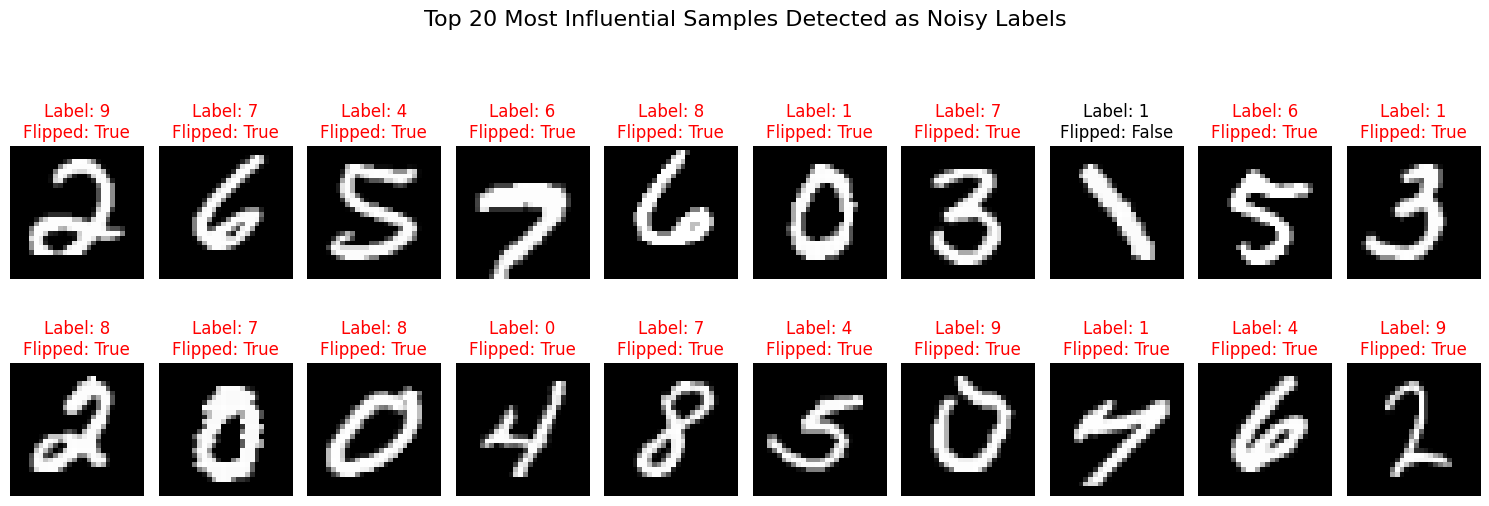

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# number of top influential samples
num_display = 20

# get the indices of the top influential samples
top_influential_indices = indices[:num_display]

plt.figure(figsize=(15, 6))
plt.suptitle(f'Top {num_display} Most Influential Samples Detected as Noisy Labels', fontsize=16)

for i, original_idx in enumerate(top_influential_indices):
    original_idx = int(original_idx)
    image, label = dataset[original_idx]

    # check if this sample was actually a flipped label
    is_flipped = original_idx in set(flip_index)

    plt.subplot(2, (num_display + 1) // 2, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title(f'Label: {label}\nFlipped: {is_flipped}', color='red' if is_flipped else 'black')
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # adjust layout to prevent title overlap
plt.show()